In [1]:
# Import necessary libraries and modules for text preprocessing, analysis, and visualization
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import nltk
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

import datetime as dt
from datetime import datetime

%matplotlib inline

In [2]:
# Import data files from repository
apple = pd.read_csv('/content/drive/MyDrive/Project UCD/Combined Data/aapl_combined.csv')
google = pd.read_csv('/content/drive/MyDrive/Project UCD/Combined Data/goog_combined.csv')
microsoft = pd.read_csv('/content/drive/MyDrive/Project UCD/Combined Data/msft_combined.csv')
nvidia = pd.read_csv('/content/drive/MyDrive/Project UCD/Combined Data/nvda_combined.csv')
tesla = pd.read_csv('/content/drive/MyDrive/Project UCD/Combined Data/tsla_combined.csv')

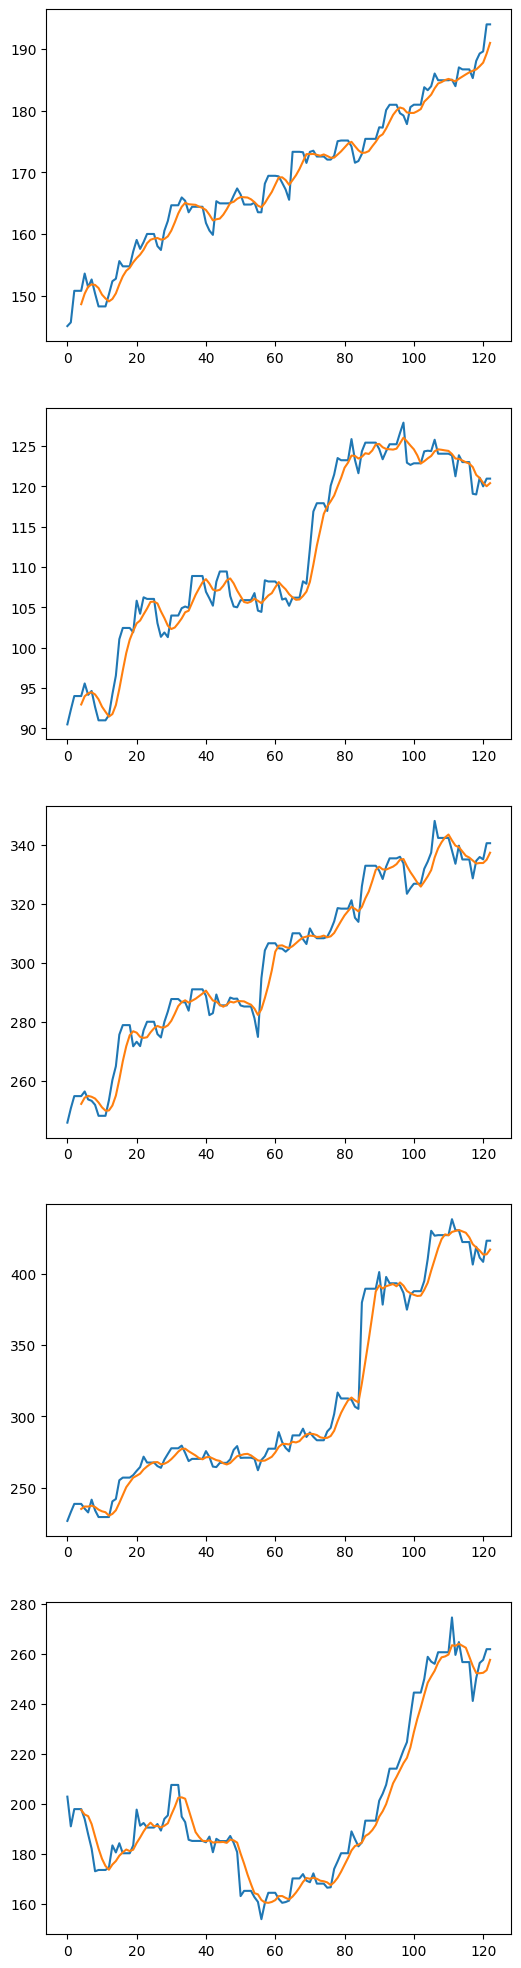

In [3]:
# setting figure size
plt.figure(figsize=(6,25))

# plotting the adj_close price and a 5-day rolling mean of adj_close price
# apple
plt.subplot(5,1,1)
plt.plot(apple[['adj_close']])
plt.plot(apple.rolling(window=5).mean()['adj_close'])
# google
plt.subplot(5,1,2)
plt.plot(google[['adj_close']])
plt.plot(google.rolling(window=5).mean()['adj_close'])
# microsoft
plt.subplot(5,1,3)
plt.plot(microsoft[['adj_close']])
plt.plot(microsoft.rolling(window=5).mean()['adj_close'])
# nvidia
plt.subplot(5,1,4)
plt.plot(nvidia[['adj_close']])
plt.plot(nvidia.rolling(window=5).mean()['adj_close'])
# tesla
plt.subplot(5,1,5)
plt.plot(tesla[['adj_close']])
plt.plot(tesla.rolling(window=5).mean()['adj_close'])

In [4]:
# Convert 'date' column to datetime format
apple['date'] = pd.to_datetime(apple['date'])
google['date'] = pd.to_datetime(google['date'])
microsoft['date'] = pd.to_datetime(microsoft['date'])
nvidia['date'] = pd.to_datetime(nvidia['date'])
tesla['date'] = pd.to_datetime(tesla['date'])

# Filter data for test period (01-06-2023 to 01-07-2023)
test_start_date = pd.Timestamp('2023-06-10')
test_end_date = pd.Timestamp('2023-07-01')

test_data_aapl = apple[(apple['date'] >= test_start_date) & (apple['date'] <= test_end_date)]
test_data_goog = google[(google['date'] >= test_start_date) & (google['date'] <= test_end_date)]
test_data_msft = microsoft[(microsoft['date'] >= test_start_date) & (microsoft['date'] <= test_end_date)]
test_data_nvda = nvidia[(nvidia['date'] >= test_start_date) & (nvidia['date'] <= test_end_date)]
test_data_tsla = tesla[(tesla['date'] >= test_start_date) & (tesla['date'] <= test_end_date)]

In [5]:
# Filter data for training period
train_data_aapl = apple[apple['date'] < test_start_date]
train_data_goog = google[google['date'] < test_start_date]
train_data_msft = microsoft[microsoft['date'] < test_start_date]
train_data_nvda = nvidia[nvidia['date'] < test_start_date]
train_data_tsla = tesla[tesla['date'] < test_start_date]

# Display the sizes of training and test sets
print("Training Data Size:", len(train_data_aapl))
print("Training Data Size:", len(train_data_goog))
print("Training Data Size:", len(train_data_msft))
print("Training Data Size:", len(train_data_nvda))
print("Training Data Size:", len(train_data_tsla))
print("Test Data Size:", len(test_data_aapl))
print("Test Data Size:", len(test_data_goog))
print("Test Data Size:", len(test_data_msft))
print("Test Data Size:", len(test_data_nvda))
print("Test Data Size:", len(test_data_tsla))

Training Data Size: 101
Training Data Size: 101
Training Data Size: 101
Training Data Size: 101
Training Data Size: 101
Test Data Size: 22
Test Data Size: 22
Test Data Size: 22
Test Data Size: 22
Test Data Size: 22


In [6]:
# setting the target variable as the shifted close_price
y_aapl = apple['adj_close']
y_goog = google['adj_close']
y_msft = microsoft['adj_close']
y_nvda = nvidia['adj_close']
y_tsla = tesla['adj_close']

In [7]:
# setting the features dataset for prediction with sentiment scores
cols = ['w_comp', 'w_subj', 'open', 'high', 'low', 'volume']
x_aapl = apple[cols]
x_goog = google[cols]
x_msft = microsoft[cols]
x_nvda = nvidia[cols]
x_tsla = tesla[cols]

In [8]:
# scaling the feature dataset
scaler_x_aapl = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_aapl = np.array(x_aapl).reshape((len(x_aapl),len(cols)))
x_aapl = scaler_x_aapl.fit_transform(x_aapl)

scaler_x_goog = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_goog = np.array(x_goog).reshape((len(x_goog),len(cols)))
x_goog = scaler_x_goog.fit_transform(x_goog)

scaler_x_msft = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_msft = np.array(x_msft).reshape((len(x_msft),len(cols)))
x_msft = scaler_x_msft.fit_transform(x_msft)

scaler_x_nvda = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_nvda = np.array(x_nvda).reshape((len(x_nvda),len(cols)))
x_nvda = scaler_x_nvda.fit_transform(x_nvda)

scaler_x_tsla = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_tsla = np.array(x_tsla).reshape((len(x_tsla),len(cols)))
x_tsla = scaler_x_tsla.fit_transform(x_tsla)

In [9]:
# scaling the target variable
scaler_y_aapl = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_aapl = np.array(y_aapl).reshape((len(y_aapl), 1))
y_aapl = scaler_y_aapl.fit_transform(y_aapl)

scaler_y_goog = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_goog = np.array(y_goog).reshape((len(y_goog), 1))
y_goog = scaler_y_goog.fit_transform(y_goog)

scaler_y_msft = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_msft = np.array(y_msft).reshape((len(y_msft), 1))
y_msft = scaler_y_msft.fit_transform(y_msft)

scaler_y_nvda = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_nvda = np.array(y_nvda).reshape((len(y_nvda), 1))
y_nvda = scaler_y_nvda.fit_transform(y_nvda)

scaler_y_tsla = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_tsla = np.array(y_tsla).reshape((len(y_tsla), 1))
y_tsla = scaler_y_tsla.fit_transform(y_tsla)

In [10]:
train_size = 101
# preparing training and test dataset
X_train_aapl = x_aapl[0 : train_size,]
X_train_goog = x_goog[0 : train_size,]
X_train_msft = x_msft[0 : train_size,]
X_train_nvda = x_nvda[0 : train_size,]
X_train_tsla = x_tsla[0 : train_size,]

X_test_aapl = x_aapl[train_size : len(x_aapl),]
X_test_goog = x_goog[train_size : len(x_goog),]
X_test_msft = x_msft[train_size : len(x_msft),]
X_test_nvda = x_nvda[train_size : len(x_nvda),]
X_test_tsla = x_tsla[train_size : len(x_tsla),]

y_train_aapl = y_aapl[0 : train_size]
y_train_goog = y_goog[0 : train_size]
y_train_msft = y_msft[0 : train_size]
y_train_nvda = y_nvda[0 : train_size]
y_train_tsla = y_tsla[0 : train_size]

y_test_aapl = y_aapl[train_size : len(y_aapl)]
y_test_goog = y_goog[train_size : len(y_goog)]
y_test_msft = y_msft[train_size : len(y_msft)]
y_test_nvda = y_nvda[train_size : len(y_nvda)]
y_test_tsla = y_tsla[train_size : len(y_tsla)]


In [11]:
# reshaping the feature dataset for feeding into the model
X_train_aapl = X_train_aapl.reshape (X_train_aapl.shape + (1,))
X_train_goog = X_train_goog.reshape (X_train_goog.shape + (1,))
X_train_msft = X_train_msft.reshape (X_train_msft.shape + (1,))
X_train_nvda = X_train_nvda.reshape (X_train_nvda.shape + (1,))
X_train_tsla = X_train_tsla.reshape (X_train_tsla.shape + (1,))

X_test_aapl = X_test_aapl.reshape(X_test_aapl.shape + (1,))
X_test_goog = X_test_goog.reshape(X_test_goog.shape + (1,))
X_test_msft = X_test_msft.reshape(X_test_msft.shape + (1,))
X_test_nvda = X_test_nvda.reshape(X_test_nvda.shape + (1,))
X_test_tsla = X_test_tsla.reshape(X_test_tsla.shape + (1,))

# printing the re-shaped feature dataset
print(X_train_aapl.shape , y_train_aapl.shape)
print(X_test_aapl.shape , y_test_aapl.shape)
print(X_train_goog.shape , y_train_goog.shape)
print(X_test_goog.shape , y_test_goog.shape)
print(X_train_msft.shape , y_train_msft.shape)
print(X_test_msft.shape , y_test_msft.shape)
print(X_train_nvda.shape , y_train_nvda.shape)
print(X_test_nvda.shape , y_test_nvda.shape)
print(X_train_tsla.shape , y_train_tsla.shape)
print(X_test_tsla.shape , y_test_tsla.shape)

(101, 6, 1) (101, 1)
(22, 6, 1) (22, 1)
(101, 6, 1) (101, 1)
(22, 6, 1) (22, 1)
(101, 6, 1) (101, 1)
(22, 6, 1) (22, 1)
(101, 6, 1) (101, 1)
(22, 6, 1) (22, 1)
(101, 6, 1) (101, 1)
(22, 6, 1) (22, 1)


In [12]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(123)

# setting the model architecture
# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=False, input_shape=(len(cols), 1)))
# Adding 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False, kernel_regularizer=l2(0.1)))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# fitting the model using the training dataset
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# printing the model summary
model.summary()

# fit the model
history_aapl = model.fit(X_train_aapl, y_train_aapl, shuffle=False, epochs=60,
                         callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 0.1874
Epoch 1: val_loss improved from inf to 0.13989, saving model to weights.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1874 - val_loss: 0.1399 - lr: 0.0100
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 0.085

In [13]:
# performing predictions
train_pred_aapl = model.predict(X_train_aapl)
# unscaling the predictions
train_pred_aapl = scaler_y_aapl.inverse_transform(np.array(train_pred_aapl).reshape((len(train_pred_aapl), 1)))
# printing the predictions
print('Train Predictions AAPL:')
train_pred_aapl[0:5]

# performing predictions
test_pred_aapl = model.predict(X_test_aapl)
# unscaling the predictions
test_pred_aapl = scaler_y_aapl.inverse_transform(np.array(test_pred_aapl).reshape((len(test_pred_aapl), 1)))
# printing the predictions
print('Test Predictions AAPL:')
test_pred_aapl[0:5]

# calculating the training mean-squared-error
train_loss_aapl = model.evaluate(X_train_aapl, y_train_aapl, batch_size = 1)
# calculating the test mean-squared-error
test_loss_aapl = model.evaluate(X_test_aapl, y_test_aapl, batch_size = 1)
# printing the training and the test mean-squared-errors
print('Train Loss AAPL=', round(train_loss_aapl,4))
print('Test Loss AAPL=', round(test_loss_aapl,4))

4/4 [==============================] - 1s 4ms/step
Train Predictions AAPL:
1/1 [==============================] - 0s 24ms/step
Test Predictions AAPL:
22/22 [==============================] - 0s 2ms/step - loss: 0.0167
Train Loss AAPL= 0.0023
Test Loss AAPL= 0.0167


In [14]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(123)

# setting the model architecture
# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=False, input_shape=(len(cols), 1)))
# Adding 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False, kernel_regularizer=l2(0.1)))
# Adding Dropout
model.add(Dropout(0.2))
# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# fitting the model using the training dataset
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# printing the model summary
model.summary()

# fit the model
history_goog = model.fit(X_train_goog, y_train_goog, shuffle=False, epochs=60,
                         callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 0.2021
Epoch 1: val_loss improved from inf to 0.55976, saving model to weights.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2021 - val_loss: 0.5598 - lr: 0.0100
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 0.1

In [15]:
# performing predictions
train_pred_goog = model.predict(X_train_goog)
# unscaling the predictions
train_pred_goog = scaler_y_goog.inverse_transform(np.array(train_pred_goog).reshape((len(train_pred_goog), 1)))
# printing the predictions
print('Train Predictions AAPL:')
train_pred_goog[0:5]

# performing predictions
test_pred_goog = model.predict(X_test_goog)
# unscaling the predictions
test_pred_goog = scaler_y_goog.inverse_transform(np.array(test_pred_goog).reshape((len(test_pred_goog), 1)))
# printing the predictions
print('Test Predictions GOOG:')
test_pred_goog[0:5]

# calculating the training mean-squared-error
train_loss_goog = model.evaluate(X_train_goog, y_train_goog, batch_size = 1)
# calculating the test mean-squared-error
test_loss_goog = model.evaluate(X_test_goog, y_test_goog, batch_size = 1)
# printing the training and the test mean-squared-errors
print('Train Loss GOOG=', round(train_loss_goog,4))
print('Test Loss GOOG=', round(test_loss_goog,4))

4/4 [==============================] - 0s 3ms/step
Train Predictions AAPL:
1/1 [==============================] - 0s 16ms/step
Test Predictions GOOG:
22/22 [==============================] - 0s 1ms/step - loss: 0.0043
Train Loss GOOG= 0.0027
Test Loss GOOG= 0.0043


In [16]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(123)

# setting the model architecture
# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=False, input_shape=(len(cols), 1)))
# Adding 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False, kernel_regularizer=l2(0.1)))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# fitting the model using the training dataset
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# printing the model summary
model.summary()

# fit the model
history_msft = model.fit(X_train_msft, y_train_msft, shuffle=False, epochs=60,
                         callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 0.1724
Epoch 1: val_loss improved from inf to 0.36231, saving model to weights.h5
1/1 [==============================] - 2s 2s/step - loss: 0.1724 - val_loss: 0.3623 - lr: 0.0100
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 0.0

In [17]:
# performing predictions
train_pred_msft = model.predict(X_train_msft)
# unscaling the predictions
train_pred_msft = scaler_y_msft.inverse_transform(np.array(train_pred_msft).reshape((len(train_pred_msft), 1)))
# printing the predictions
print('Train Predictions MSFT:')
train_pred_msft[0:5]

# performing predictions
test_pred_msft = model.predict(X_test_msft)
# unscaling the predictions
test_pred_msft = scaler_y_msft.inverse_transform(np.array(test_pred_msft).reshape((len(test_pred_msft), 1)))
# printing the predictions
print('Test Predictions MSFT:')
test_pred_msft[0:5]

# calculating the training mean-squared-error
train_loss_msft = model.evaluate(X_train_msft, y_train_msft, batch_size = 1)
# calculating the test mean-squared-error
test_loss_msft = model.evaluate(X_test_msft, y_test_msft, batch_size = 1)
# printing the training and the test mean-squared-errors
print('Train Loss MSFT=', round(train_loss_msft,4))
print('Test Loss MSFT=', round(test_loss_msft,4))

4/4 [==============================] - 0s 3ms/step
Train Predictions MSFT:
1/1 [==============================] - 0s 25ms/step
Test Predictions MSFT:
22/22 [==============================] - 0s 1ms/step - loss: 0.0056
Train Loss MSFT= 0.0024
Test Loss MSFT= 0.0056


In [18]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(123)

# setting the model architecture
# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=70, return_sequences=False, input_shape=(len(cols), 1)))
# Adding 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False, kernel_regularizer=l2(0.1)))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# fitting the model using the training dataset
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# printing the model summary
model.summary()

# fit the model
history_nvda = model.fit(X_train_nvda, y_train_nvda, shuffle=False, epochs=100,
                         callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 70)                20160     
                                                                 
 dropout_3 (Dropout)         (None, 70)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4450
Epoch 1: val_loss improved from inf to 0.32502, saving model to weights.h5
1/1 [==============================] - 2s 2s/step - loss: 0.4450 - val_loss: 0.3250 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0

In [19]:
# performing predictions
train_pred_nvda = model.predict(X_train_nvda)
# unscaling the predictions
train_pred_nvda = scaler_y_nvda.inverse_transform(np.array(train_pred_nvda).reshape((len(train_pred_nvda), 1)))
# printing the predictions
print('Train Predictions NVDA:')
train_pred_nvda[0:5]

# performing predictions
test_pred_nvda = model.predict(X_test_nvda)
# unscaling the predictions
test_pred_nvda = scaler_y_nvda.inverse_transform(np.array(test_pred_nvda).reshape((len(test_pred_nvda), 1)))
# printing the predictions
print('Test Predictions NVDA:')
test_pred_nvda[0:5]

# calculating the training mean-squared-error
train_loss_nvda = model.evaluate(X_train_nvda, y_train_nvda, batch_size = 1)
# calculating the test mean-squared-error
test_loss_nvda = model.evaluate(X_test_nvda, y_test_nvda, batch_size = 1)
# printing the training and the test mean-squared-errors
print('Train Loss NVDA=', round(train_loss_nvda,4))
print('Test Loss NVDA=', round(test_loss_nvda,4))

4/4 [==============================] - 0s 3ms/step
Train Predictions NVDA:
1/1 [==============================] - 0s 22ms/step
Test Predictions NVDA:
22/22 [==============================] - 0s 2ms/step - loss: 0.0678
Train Loss NVDA= 0.0047
Test Loss NVDA= 0.0678


In [20]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(123)

# setting the model architecture
# Initializing the Neural Network based on LSTM
model = Sequential()
# Adding 1st LSTM layer
model.add(LSTM(units=70, return_sequences=False, input_shape=(len(cols), 1)))
# Adding 2nd LSTM layer
#model.add(LSTM(units=10, return_sequences=False, kernel_regularizer=l2(0.1)))
# Adding Dropout
model.add(Dropout(0.3))
# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

# fitting the model using the training dataset
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# printing the model summary
model.summary()

# fit the model
history_tsla = model.fit(X_train_tsla, y_train_tsla, shuffle=False, epochs=100,
                         callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70)                20160     
                                                                 
 dropout_4 (Dropout)         (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3536
Epoch 1: val_loss improved from inf to 0.04414, saving model to weights.h5
1/1 [==============================] - 3s 3s/step - loss: 0.3536 - val_loss: 0.0441 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0

In [21]:
# performing predictions
train_pred_tsla = model.predict(X_train_tsla)
# unscaling the predictions
train_pred_tsla = scaler_y_tsla.inverse_transform(np.array(train_pred_tsla).reshape((len(train_pred_tsla), 1)))
# printing the predictions
print('Train Predictions TSLA:')
train_pred_tsla[0:5]

# performing predictions
test_pred_tsla = model.predict(X_test_tsla)
# unscaling the predictions
test_pred_tsla = scaler_y_tsla.inverse_transform(np.array(test_pred_tsla).reshape((len(test_pred_tsla), 1)))
# printing the predictions
print('Test Predictions TSLA:')
test_pred_tsla[0:5]

# calculating the training mean-squared-error
train_loss_tsla = model.evaluate(X_train_tsla, y_train_tsla, batch_size = 1)
# calculating the test mean-squared-error
test_loss_tsla = model.evaluate(X_test_tsla, y_test_tsla, batch_size = 1)
# printing the training and the test mean-squared-errors
print('Train Loss TSLA=', round(train_loss_tsla,4))
print('Test Loss TSLA=', round(test_loss_tsla,4))

4/4 [==============================] - 0s 4ms/step
Train Predictions TSLA:
1/1 [==============================] - 0s 21ms/step
Test Predictions TSLA:
22/22 [==============================] - 0s 1ms/step - loss: 0.0234
Train Loss TSLA= 0.0024
Test Loss TSLA= 0.0234


In [22]:
# unscaling the test feature dataset, x_test
X_test_aapl = scaler_x_aapl.inverse_transform(np.array(X_test_aapl).reshape((len(X_test_aapl), len(cols))))
X_test_goog = scaler_x_goog.inverse_transform(np.array(X_test_goog).reshape((len(X_test_goog), len(cols))))
X_test_msft = scaler_x_msft.inverse_transform(np.array(X_test_msft).reshape((len(X_test_msft), len(cols))))
X_test_nvda = scaler_x_nvda.inverse_transform(np.array(X_test_nvda).reshape((len(X_test_nvda), len(cols))))
X_test_tsla = scaler_x_tsla.inverse_transform(np.array(X_test_tsla).reshape((len(X_test_tsla), len(cols))))

# unscaling the test y dataset, y_train
y_train_aapl = scaler_y_aapl.inverse_transform(np.array(y_train_aapl).reshape((len(y_train_aapl), 1)))
y_train_goog = scaler_y_goog.inverse_transform(np.array(y_train_goog).reshape((len(y_train_goog), 1)))
y_train_msft = scaler_y_msft.inverse_transform(np.array(y_train_msft).reshape((len(y_train_msft), 1)))
y_train_nvda = scaler_y_nvda.inverse_transform(np.array(y_train_nvda).reshape((len(y_train_nvda), 1)))
y_train_tsla = scaler_y_tsla.inverse_transform(np.array(y_train_tsla).reshape((len(y_train_tsla), 1)))

# unscaling the test y dataset, y_test
y_test_aapl = scaler_y_aapl.inverse_transform(np.array(y_test_aapl).reshape((len(y_test_aapl), 1)))
y_test_goog = scaler_y_goog.inverse_transform(np.array(y_test_goog).reshape((len(y_test_goog), 1)))
y_test_msft = scaler_y_msft.inverse_transform(np.array(y_test_msft).reshape((len(y_test_msft), 1)))
y_test_nvda = scaler_y_nvda.inverse_transform(np.array(y_test_nvda).reshape((len(y_test_nvda), 1)))
y_test_tsla = scaler_y_tsla.inverse_transform(np.array(y_test_tsla).reshape((len(y_test_tsla), 1)))

In [23]:
# calculating root mean squared error using sklearn.metrics package
rmse_aapl = np.sqrt(metrics.mean_squared_error(y_test_aapl, test_pred_aapl))
rmse_goog = np.sqrt(metrics.mean_squared_error(y_test_goog, test_pred_goog))
rmse_msft = np.sqrt(metrics.mean_squared_error(y_test_msft, test_pred_msft))
rmse_nvda = np.sqrt(metrics.mean_squared_error(y_test_nvda, test_pred_nvda))
rmse_tsla = np.sqrt(metrics.mean_squared_error(y_test_tsla, test_pred_tsla))
# calculating mean squared error using sklearn.metrics package
mae_aapl = metrics.mean_absolute_error(y_test_aapl, test_pred_aapl)
mae_goog = metrics.mean_absolute_error(y_test_goog, test_pred_goog)
mae_msft = metrics.mean_absolute_error(y_test_msft, test_pred_msft)
mae_nvda = metrics.mean_absolute_error(y_test_nvda, test_pred_nvda)
mae_tsla = metrics.mean_absolute_error(y_test_tsla, test_pred_tsla)
# calculating absolute mean squared error using sklearn.metrics package
mape_aapl = metrics.mean_absolute_percentage_error(y_test_aapl, test_pred_aapl)
mape_goog = metrics.mean_absolute_percentage_error(y_test_goog, test_pred_goog)
mape_msft = metrics.mean_absolute_percentage_error(y_test_msft, test_pred_msft)
mape_nvda = metrics.mean_absolute_percentage_error(y_test_nvda, test_pred_nvda)
mape_tsla = metrics.mean_absolute_percentage_error(y_test_tsla, test_pred_tsla)

In [24]:
# Create array containing performance metrics
aapl_with_sentiment = np.array([("RMSE_aapl", rmse_aapl),("MAE_aapl", mae_aapl),("MAPE_aapl", mape_aapl)])
goog_with_sentiment = np.array([("RMSE_goog", rmse_goog),("MAE_goog", mae_goog),("MAPE_goog", mape_goog)])
msft_with_sentiment = np.array([("RMSE_msft", rmse_msft),("MAE_msft", mae_msft),("MAPE_msft", mape_msft)])
nvda_with_sentiment = np.array([("RMSE_nvda", rmse_nvda),("MAE_nvda", mae_nvda),("MAPE_nvda", mape_nvda)])
tsla_with_sentiment = np.array([("RMSE_tsla", rmse_tsla),("MAE_tsla", mae_tsla),("MAPE_tsla", mape_tsla)])
# Print the metrics
print(aapl_with_sentiment)
print(goog_with_sentiment)
print(msft_with_sentiment)
print(nvda_with_sentiment)
print(tsla_with_sentiment)

[['RMSE_aapl' '3.1564657412873105']
 ['MAE_aapl' '2.6640979516601546']
 ['MAPE_aapl' '0.014217725804506599']]
[['RMSE_goog' '1.2226141258663599']
 ['MAE_goog' '0.9390872301358328']
 ['MAPE_goog' '0.007637329651195502']]
[['RMSE_msft' '3.8469565480465056']
 ['MAE_msft' '3.5717260212180353']
 ['MAPE_msft' '0.01057767924840251']]
[['RMSE_nvda' '27.49225362624489']
 ['MAE_nvda' '26.710555838068206']
 ['MAPE_nvda' '0.06355263220093202']]
[['RMSE_tsla' '9.226291023427041']
 ['MAE_tsla' '7.903712949884592']
 ['MAPE_tsla' '0.030483342823506513']]


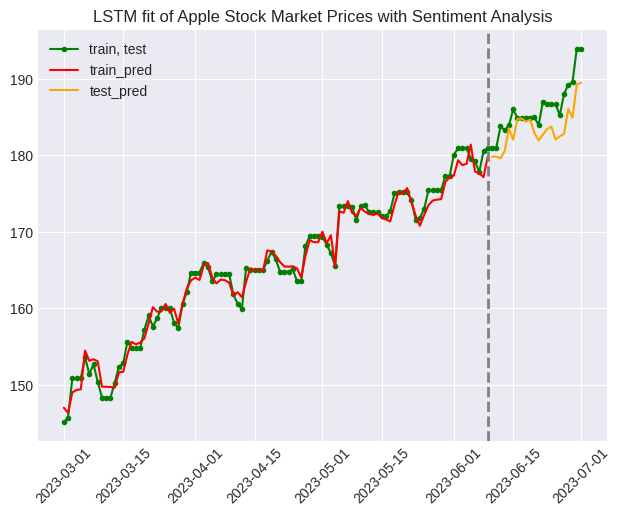

In [25]:
# Plotting the LSTM fit of Apple stock prices with sentiment analysis
aapl_y_train = pd.DataFrame(data = y_train_aapl, index = apple['date'].iloc[0:101,])
aapl_y_test  = pd.DataFrame(data = y_test_aapl, index = apple['date'].iloc[101:,])
aapl_y_train_pred = pd.DataFrame(data = train_pred_aapl, index = apple['date'].iloc[0:101,])
aapl_y_test_pred  = pd.DataFrame(data = test_pred_aapl, index = apple['date'].iloc[101:,])

plt.style.use('seaborn-dark')

plt.plot(aapl_y_train,label = "train, test",color ="green",marker='.')
plt.plot(aapl_y_test,label = "",color ="green",marker='.')
plt.plot(aapl_y_train_pred,color="red", label = "train_pred")
plt.plot(aapl_y_test_pred,color="orange", label = "test_pred")
plt.title("LSTM fit of Apple Stock Market Prices with Sentiment Analysis")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend()
plt.grid()
plt.xticks(rotation = 45)
plt.axvline(x = max(aapl_y_train.index),color ="gray", linewidth=2, linestyle='--')
plt.show();

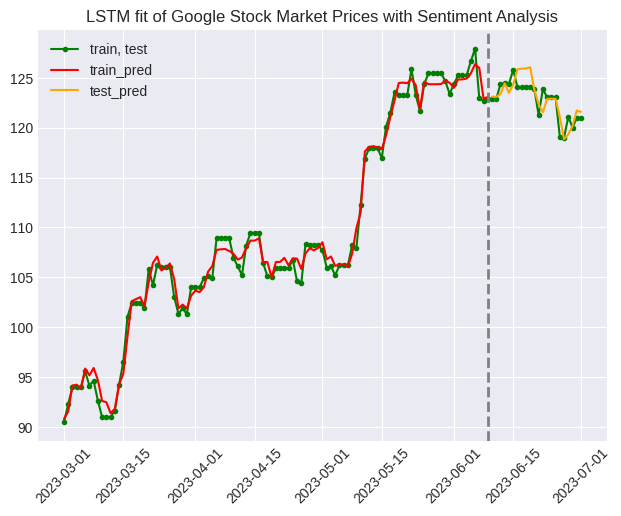

In [26]:
# Plotting the LSTM fit of Google stock prices with sentiment analysis
goog_y_train = pd.DataFrame(data = y_train_goog, index = google['date'].iloc[0:101,])
goog_y_test  = pd.DataFrame(data = y_test_goog, index = google['date'].iloc[101:,])
goog_y_train_pred = pd.DataFrame(data = train_pred_goog, index = google['date'].iloc[0:101,])
goog_y_test_pred  = pd.DataFrame(data = test_pred_goog, index = google['date'].iloc[101:,])

plt.style.use('seaborn-dark')

plt.plot(goog_y_train,label = "train, test",color ="green",marker='.')
plt.plot(goog_y_test,label = "",color ="green",marker='.')
plt.plot(goog_y_train_pred,color="red",label = "train_pred")
plt.plot(goog_y_test_pred,color="orange", label = "test_pred")
plt.title("LSTM fit of Google Stock Market Prices with Sentiment Analysis")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend()
plt.grid()
plt.xticks(rotation = 45)
plt.axvline(x = max(goog_y_train.index),color ="gray", linewidth=2, linestyle='--')
plt.show();

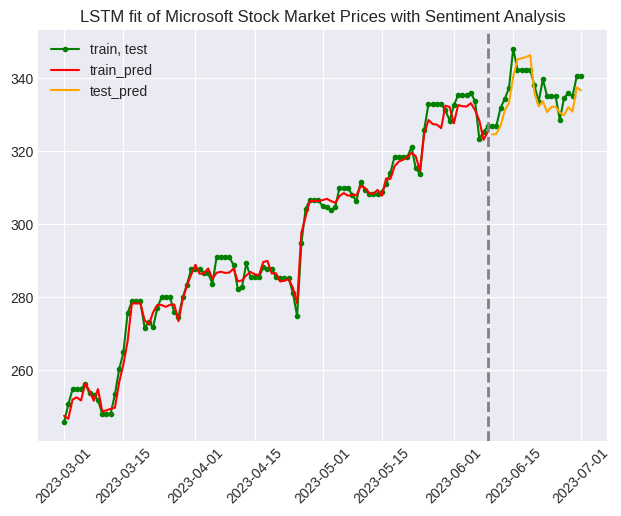

In [27]:
# Plotting the LSTM fit of Microsoft stock prices with sentiment analysis
msft_y_train = pd.DataFrame(data = y_train_msft, index = microsoft['date'].iloc[0:101,])
msft_y_test  = pd.DataFrame(data = y_test_msft, index = microsoft['date'].iloc[101:,])
msft_y_train_pred = pd.DataFrame(data = train_pred_msft, index = microsoft['date'].iloc[0:101,])
msft_y_test_pred  = pd.DataFrame(data = test_pred_msft, index = microsoft['date'].iloc[101:,])

plt.style.use('seaborn-dark')

plt.plot(msft_y_train,label = "train, test",color ="green",marker='.')
plt.plot(msft_y_test,label = "",color ="green",marker='.')
plt.plot(msft_y_train_pred,color="red",label = "train_pred")
plt.plot(msft_y_test_pred,color="orange",label = "test_pred")
plt.title("LSTM fit of Microsoft Stock Market Prices with Sentiment Analysis")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend()
plt.grid()
plt.xticks(rotation = 45)
plt.axvline(x = max(msft_y_train.index),color ="gray", linewidth=2, linestyle='--')
plt.show();

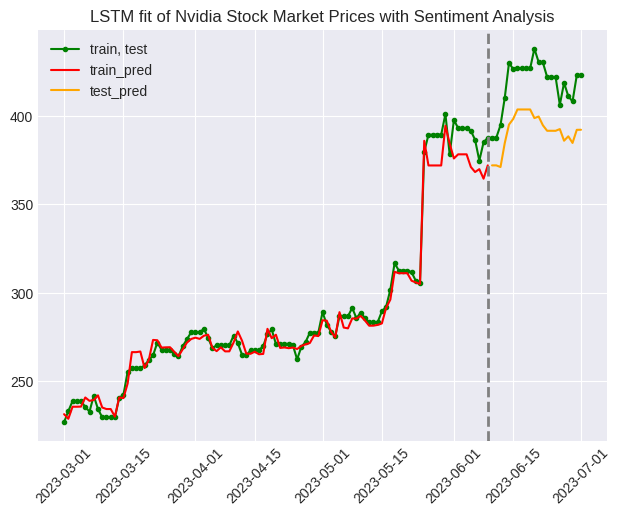

In [28]:
# Plotting the LSTM fit of Nvidia stock prices with sentiment analysis
nvda_y_train = pd.DataFrame(data = y_train_nvda, index = nvidia['date'].iloc[0:101,])
nvda_y_test  = pd.DataFrame(data = y_test_nvda, index = nvidia['date'].iloc[101:,])
nvda_y_train_pred = pd.DataFrame(data = train_pred_nvda, index = nvidia['date'].iloc[0:101,])
nvda_y_test_pred  = pd.DataFrame(data = test_pred_nvda, index = nvidia['date'].iloc[101:,])

plt.style.use('seaborn-dark')

plt.plot(nvda_y_train,label = "train, test",color ="green",marker='.')
plt.plot(nvda_y_test,label = "",color ="green",marker='.')
plt.plot(nvda_y_train_pred,color="red",label = "train_pred")
plt.plot(nvda_y_test_pred,color="orange",label = "test_pred")
plt.title("LSTM fit of Nvidia Stock Market Prices with Sentiment Analysis")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend()
plt.grid()
plt.xticks(rotation = 45)
plt.axvline(x = max(nvda_y_train.index),color ="gray", linewidth=2, linestyle='--')
plt.show();

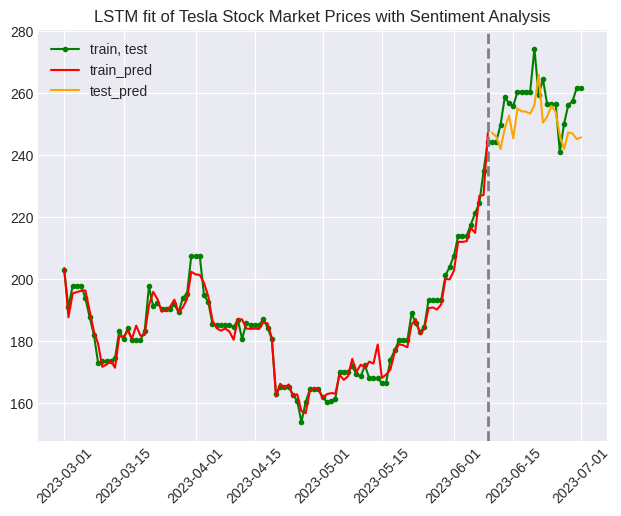

In [29]:
# Plotting the LSTM fit of Tesla stock prices with sentiment analysis
tsla_y_train = pd.DataFrame(data = y_train_tsla, index = tesla['date'].iloc[0:101,])
tsla_y_test  = pd.DataFrame(data = y_test_tsla, index = tesla['date'].iloc[101:,])
tsla_y_train_pred = pd.DataFrame(data = train_pred_tsla, index = tesla['date'].iloc[0:101,])
tsla_y_test_pred  = pd.DataFrame(data = test_pred_tsla, index = tesla['date'].iloc[101:,])

plt.style.use('seaborn-dark')

plt.plot(tsla_y_train, label = "train, test", color ="green",marker='.')
plt.plot(tsla_y_train_pred, color="red",label = "train_pred")
plt.plot(tsla_y_test, label = "", color ="green",marker='.')
plt.plot(tsla_y_test_pred, color="orange", label = "test_pred")
plt.title("LSTM fit of Tesla Stock Market Prices with Sentiment Analysis")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend()
plt.grid()
plt.xticks(rotation = 45)
plt.axvline(x = max(tsla_y_train.index),color ="gray", linewidth=2, linestyle='--')
plt.show();